# Ensemble Learning through Batch Boosting


In [387]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

## Parameter Configuration

In [388]:
np.random.seed(2020)

In [389]:
N_train = 1000
N_test = 10000
Epsilon  = 1e-3
Max_Iter = 50
Learning_Rate = 0.366
Ratio = 0.4
ratios = [0.15]
d = 1
T = 2

In [390]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [320]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [396]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [397]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_T_train = s_train.generate_true_V(T)
V_0_train = s_train.generate_true_V(0)

V_0_train = V_0_train.mean()
V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.08026053817102533

In [398]:
from aggregating.utils import flatten_X, normalized_error_VT
#dim(N_test,d*T)
Flattened_X_test = flatten_X(X_test)
# dim(N_train, d*T)
Flattened_X_train = flatten_X(X_train)

In [399]:
#Model with Flatten_X_1
m_1 = GaussianProcessRegressor(kernel)
m_1.fit(Flattened_X_train,y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=2.5))

In [400]:
fX_1 = m_1.predict(Flattened_X_test)

In [401]:
fX_2 = m_1.predict(Flattened_X_train)

In [402]:
fX_2


array([-1.46980755e-03,  2.88337340e-01, -4.90059871e-04, -2.39398554e-03,
        2.27631704e-02,  1.40489940e-01,  8.77683498e-02,  1.40120660e-03,
        8.50934892e-02, -2.54856950e-03, -4.26231208e-04, -2.18785916e-03,
        2.06226484e-01, -1.98650606e-03,  7.83381597e-04,  4.86929618e-03,
        1.11204014e-03,  1.15031896e-01,  2.58852703e-01, -1.78536259e-03,
       -8.88091329e-04,  1.02154874e-01, -1.47126170e-03,  2.41733612e-01,
        4.82180680e-04, -2.02945148e-03,  2.86021503e-03, -2.60429898e-03,
        9.73054268e-02,  2.77228599e-03, -8.78521431e-04, -8.01840342e-04,
        2.03608028e-02,  1.47607951e-03, -2.64895233e-03,  1.42006621e-01,
        1.07094567e-01,  9.32494164e-04,  4.78855104e-04, -8.81155291e-04,
       -2.32991586e-03,  8.18264708e-02,  4.50510163e-01, -1.01321248e-03,
        4.06656707e-03,  2.55213565e-01,  6.92062876e-02,  1.47465805e-01,
        1.48689991e-01,  1.27342274e-03, -4.93343955e-04,  5.01645095e-01,
        3.10539764e-01,  

In [403]:
test_reference_error = normalized_error_VT(fX_1 ,V_T, V_0)

In [404]:
train_reference_error = normalized_error_VT(fX_2 ,V_T_train, V_0_train)

In [405]:
train_reference_error

0.02276971514195225

In [406]:
test_reference_error 

0.2603028151408908

## Stochastic Gradient Boosting

In [395]:
def Stochastic_Gradient_Boosting(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size, init):
    np.random.seed(2020)
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    y_hat_train = np.full(len(y_train),init)

    y_hat_test = np.full(len(y_test),init)

   
    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - y_hat_train[indices])
        
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        y_hat_train += learning_rate * new_train_predictor
        
        y_hat_test += learning_rate * new_test_predictor
                
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
    
        if (( np.abs(min_error[0] - test_errors[-1]) > epsilon) & (test_errors[-1] < min_error[0])):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
        else:
            
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {}'.format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [378]:
def Stochastic_Gradient_Boosting_1(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size, fX_2, fX_1):
    np.random.seed(2020)
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    #y_hat_train = np.full(len(y_train),np.mean(y_train, axis=0))
    #y_hat_test = np.full(len(y_test),np.mean(y_train, axis=0))

    y_hat_train = 0.8*fX_2
    y_hat_test = 0.82*fX_1
    
    for i in range(Max_Iter):
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
        
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - y_hat_train[indices])
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        
        y_hat_train += learning_rate * new_train_predictor
        
        y_hat_test += learning_rate * new_test_predictor
        
        
    
        if ( (test_errors[-1] < min_error[0])):
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
        else:
            
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {}'.format(i, test_errors[-1]))
        
            if  (i==(Max_Iter-1)):
                models = models[:min_error[1]+1]
                
                return models, train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                models = models[: -(early_stop)]
                
                return models, train_errors, test_errors, min_error
                break #early stopping
            
    return models, train_errors, test_errors, min_error

In [392]:
def Stoch_Grad_Boosting_per_ratio_1(ratios, model, X_train, y_train, X_test, y_test, Epsilon, kernel, Max_Iter,stop,  learning_rate, fX_2, fX_1):
    models = dict((val, []) for val in range(len(ratios))) 
    train_errors = dict((val, []) for val in range(len(ratios))) 
    test_errors = dict((val, []) for val in range(len(ratios))) 
    min_errors = dict((val, []) for val in range(len(ratios))) 

    for i in range(len(ratios)) :
        print(f"Starting evaluation for ratio {ratios[i]}:")
        models[i], train_errors[i], test_errors[i], min_errors[i] = model(X_train, y_train, X_test, y_test, Max_Iter, (float("inf"), float("inf")), stop, kernel, learning_rate, Epsilon, round(X_train.shape[0]*ratios[i]), fX_2, fX_1)
    
    return test_errors


In [393]:
def Stoch_Grad_Boosting_per_ratio(ratios, model, X_train, y_train, X_test, y_test, Epsilon, kernel, Max_Iter,stop,  learning_rate, init):
    models = dict((val, []) for val in range(len(ratios))) 
    train_errors = dict((val, []) for val in range(len(ratios))) 
    test_errors = dict((val, []) for val in range(len(ratios))) 
    min_errors = dict((val, []) for val in range(len(ratios))) 

    for i in range(len(ratios)) :
        print(f"Starting evaluation for ratio {ratios[i]}:")
        models[i], train_errors[i], test_errors[i], min_errors[i] = model(X_train, y_train, X_test, y_test, Max_Iter, (float("inf"), float("inf")), stop, kernel, learning_rate, Epsilon, round(X_train.shape[0]*ratios[i]), init)
    
    return test_errors

In [381]:
test_errors_1 = Stoch_Grad_Boosting_per_ratio_1([0.35], Stochastic_Gradient_Boosting_1, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter,4,0.7,np.copy(fX_2), np.copy(fX_1))


Starting evaluation for ratio 0.35:
For iteration number 0, the test error decreased , test error : 0.25502954666616134 
For iteration number 1, the test error decreased , test error : 0.16548061526085137 
For iteration number 2, the test error decreased , test error : 0.15492355871841387 
For iteration number 3, the test error decreased , test error : 0.15303423109863734 
For iteration number 4, the test error decreased , test error : 0.15273719621153117 
For iteration number 5, the test error decreased , test error : 0.1526556238224395 
For iteration number 6, the test error decreased , test error : 0.15248343949575704 
For iteration number 7, the test error decreased , test error : 0.15246715335033104 
For iteration number 8, the test error decreased , test error : 0.1523728338439732 
For iteration number 9, the test error decreased , test error : 0.15235372243676126 
For iteration number 10, the test error decreased , test error : 0.15231696542094195 
For iteration number 11, the t

In [407]:
#test_errors_high_dim = Stoch_Grad_Boosting_per_ratio(ratios, Stochastic_Gradient_Boosting, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter, 0.36, np.mean(y_train, axis=0))
#test_errors_0 = Stoch_Grad_Boosting_per_ratio(ratios, Stochastic_Gradient_Boosting, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter, 0.7, 0.0)
test_errors_1 = Stoch_Grad_Boosting_per_ratio([0.25], Stochastic_Gradient_Boosting, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter,4,0.7,np.mean(y_train, axis=0))


Starting evaluation for ratio 0.25:
For iteration number 0, the test error decreased , test error : 0.5835936562950536 
For iteration number 1, the test error decreased , test error : 0.22882967848682884 
For iteration number 2, the test error decreased , test error : 0.14604059594845145 
For iteration number 3, the test error decreased , test error : 0.13358351910076371 
For iteration number 4, the test error decreased , test error : 0.13144615536006887 
For iteration number 5, the test error decreased , test error : 0.10782400278364518 
For iteration number 6, the test error increased , test error : 0.10782400278364518
For iteration number 7, the test error increased , test error : 0.10782400278364518
For iteration number 8, the test error increased , test error : 0.10782400278364518


/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 9, the test error increased , test error : 0.10782400278364518


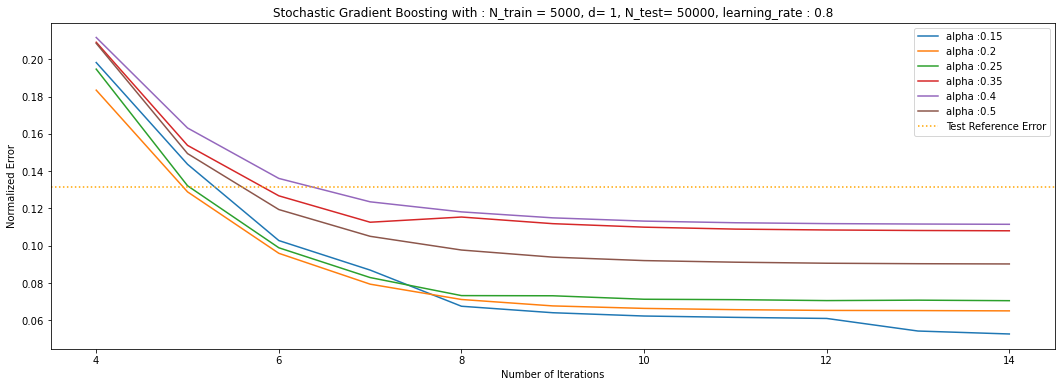

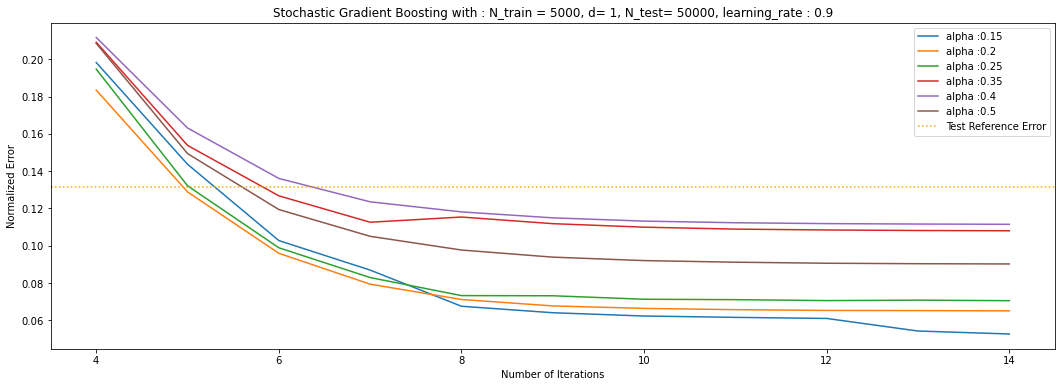

In [55]:
plot_errors(test_errors,ratios, N_train, d, N_test, Learning_Rate, Max_Iter, 0.8)

#plot_errors(test_errors_0,ratios, N_train, d, N_test, Learning_Rate, Max_Iter, '0') 
plot_errors(test_errors_1,ratios, N_train, d, N_test, Learning_Rate, Max_Iter, 0.9) 

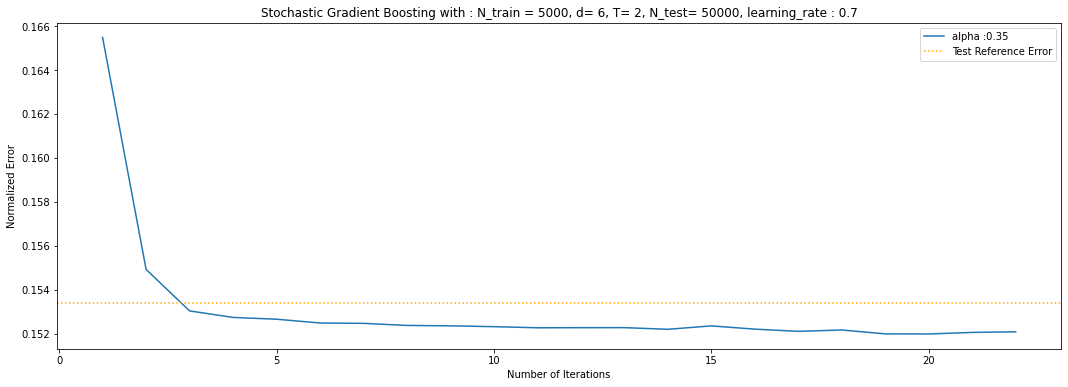

In [386]:
plot_errors(test_errors_1,[0.35], N_train, d, N_test, 0.7, Max_Iter) 

In [44]:
import pickle
with open(f"Learning_Rate_{Learning_Rate}.p", "wb") as f:
    pickle.dump(test_errors,f)

In [45]:

PICKLE = True
if PICKLE:
    test_errors_1 = pickle.load(open(f"Learning_Rate_{0.8}.p", "rb"))
    test_errors_2 = pickle.load(open(f"Learning_Rate_{0.9}.p", "rb"))
    #test_errors_1 = pickle.load(open("half_mean_initalisation.p", "rb"))

In [90]:
def log_plot_errors(test_errors, ratios, N_train, d, N_test, Learning_Rate, Max_Iter):
    for i in range(len(test_errors)):
        while len(test_errors[i]) != Max_Iter :
            test_errors[i].append(test_errors[i][-1])
    plt.figure(figsize=((18, 6)))
    for i in range(len(ratios)) :
        #plt.axvline(min_errors[i][1], ls='-', color = 'k', label = 'Test Minimal Error for rate : {rate}')
        plt.plot(np.arange(len(test_errors[i][:61])) , np.log(test_errors[i][:61]), label = f'learning rate :{ratios[i]}')
    plt.axhline(np.log(test_reference_error), ls=':', color = 'orange', label = 'Test Reference Error')
    plt.xlabel("Number of Iterations")
    plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}, learning_rate : {Learning_Rate}, with different Learning Rates")
    plt.ylabel("Log Normalized Error")
    plt.legend(loc='upper right')
    plt.show()

In [385]:
def plot_errors(test_errors, ratios, N_train, d, N_test, Learning_Rate, Max_Iter):
    
    for i in range(len(test_errors)):
        while len(test_errors[i]) != Max_Iter :
            test_errors[i].append(test_errors[i][-1])
    plt.figure(figsize=((18, 6)))
    for i in range(len(ratios)) :
       
        plt.plot(np.arange(1,23) , test_errors[i][1:23], label = f'alpha :{ratios[i]}')
        
    plt.axhline(test_reference_error, ls=':', color = 'orange', label = 'Test Reference Error')
    plt.xlabel("Number of Iterations")
    plt.title(f"Stochastic Gradient Boosting with : N_train = {N_train}, d= {d}, T= {T}, N_test= {N_test}, learning_rate : {Learning_Rate}")
    plt.ylabel("Normalized Error")
    plt.legend(loc='upper right')
    plt.show()